## Clustering

The idea behind clustering is that once we've fetched N review papers from pubmed, now what we want to do is to check to see which papers are similar to each other, and should be fed to the summarizer as a single document. We can do this by comparing the abstracts for each paper. We'll do this by taking an average of the abstract's word2vec word vectors.

In [148]:
import pandas as pd
import numpy as np
import pickle
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import gensim
import os
import collections
from collections import Counter

import smart_open
import random

import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

%matplotlib inline

## Step 1

Let's manually inspect the 5 abstracts for the papers on atrial fibrillation that you kept.

After reading through all 5 abstracts, I would say that all of these papers are about distinctly different aspects of atrial fibrillation, and that they should not be clustered together and should instead by summarized each on their own.

In [149]:
%%bash
ls documents/

ClinicalSenseInventoryII_RefinedMasterFile.txt
ClinicalSenseInventoryI_MasterFile.txt
atrial_fibrillation_review_paper_dictionary_list.pkl
dict_structure.txt
lewy_body_dementia_review_paper_dictionary_list.pkl
word_to_w2v_chunk_dict.pkl


In [150]:
# Load the list of dictionaries from the pickled files.

with open("documents/atrial_fibrillation_review_paper_dictionary_list.pkl", "rb") as picklefile:
    af_list_of_dictionaries = pickle.load(picklefile)

In [151]:
with open("documents/lewy_body_dementia_review_paper_dictionary_list.pkl", "rb") as picklefile:
    lbd_list_of_dictionaries = pickle.load(picklefile)

In [152]:
len(af_list_of_dictionaries)

36

In [153]:
len(lbd_list_of_dictionaries)

52

In [154]:
for af_dictionary in af_list_of_dictionaries:
    print(af_dictionary['title'])
    print(af_dictionary['pmcid'])
    print(str(af_dictionary['keywords']) + "\n__________________\n")

Accuracy of methods for detecting an irregular pulse and suspected atrial fibrillation: A systematic review and meta-analysis
PMC4952027
['atrial fibrillation', 'screening', 'diagnostic accuracy', 'irregular pulse']
__________________

Atrial fibrillation and the risk for myocardial infarction, all-cause mortality and heart failure: A systematic review and meta-analysis
PMC5598874
['atrial fibrillation', 'myocardial infarction', 'mortality', 'heart failure']
__________________

European Primary Care Cardiovascular Society (EPCCS) consensus guidance on stroke prevention in atrial fibrillation (SPAF) in primary care
PMC4766963
['atrial fibrillation', 'stroke prevention', 'stroke risk', 'bleeding risk', 'anticoagulation']
__________________

The effects of rhythm control strategies versus rate control strategies for atrial fibrillation and atrial flutter: A systematic review with meta-analysis and Trial Sequential Analysis
PMC5658096
[]
__________________

Atrial fibrillation and hyperthy

In [155]:
for lbd_dictionary in lbd_list_of_dictionaries:
    print(lbd_dictionary['title'])
    print(lbd_dictionary['pmcid'])
    print(str(lbd_dictionary['keywords']) + "\n__________________\n")

Non-pharmacological interventions for Lewy body dementia: a systematic review
PMC6088773
['caregiver support', 'dementia with lewy bodies', 'lewy body dementia', 'neuropsychiatric symptoms', 'non-pharmacological', "parkinson's disease dementia"]
__________________

Exercise for Individuals with Lewy Body Dementia: A Systematic Review
PMC4892610
[]
__________________

Are dementia with Lewy bodies and Parkinson’s disease dementia the same disease?
PMC5840831
['dementia with lewy bodies', 'parkinson’s disease dementia', 'clinical features', 'diagnostic criteria', 'neuropathology', 'diagnostic tests', 'management', 'synucleinopathies']
__________________

Lewy body disease and dementia with Lewy bodies
PMC4275567
['lewy body disease (lbd)', 'diffuse lewy body disease (dlbd)', 'dementia with lewy bodies (dlb)', 'parkinson’s disease (pd)', 'parkinson’s disease with dementia (pdd)']
__________________

Development of assessment toolkits for improving the diagnosis of the Lewy body dementias:

## Step 2

Let's go ahead and try averaging the word2vec vectors for each of the abstracts. The other thing to look at would be whether or not taking out the stopwords for each of the abstracts would actually help.

The first step is to go ahead and tokenize the abstract. We'll use the abstract from the first LBD paper.

In [156]:
def vectorize_abstract(abstract):
    abstract_words = word_tokenize(abstract)
    return abstract_words

Let's import the pubmed word2vec vectors. Due to the size of the vectors, we're going to just use chunks of the original file. We're also going to make a dictionary of all the words contained in each chunk file, so that we can can get the words that are contained in that file.

In [157]:
# med_w2v_chunks_path = "../../../resources/med_w2v_chunks/"

In [158]:
# with open(med_w2v_chunks_path + "directory_of_chunk_names.txt", "r") as f:
#     chunk_names = f.read().split("\n")

In [159]:
# word_to_w2v_chunk_dict = {}

In [160]:
# There are 410 w2v_chunk files. We will only use the words from the first 100 chunk files, although if it seems
# that we are missing a lot of words then I can go back and create a dictionary from all 410 files.

# for i in range(100):
#     with open(med_w2v_chunks_path + chunk_names[i], "r") as f:
#         vector_chunk = f.readlines()
#     words = [(vector.split(" ")[0], chunk_names[i]) for vector in vector_chunk]
#     word_to_w2v_chunk_dict.update(dict(words))

In [161]:
# We'll go ahead and pickle this dictionary.

# with open("documents/word_to_w2v_chunk_dict.pkl", "wb") as picklefile:
#     pickle.dump(word_to_w2v_chunk_dict, picklefile)

Now, we'll go ahead and get the word vectors for each abstract, and just look to see whether or not we can cluster different papers.

In [162]:
with open("documents/word_to_w2v_chunk_dict.pkl", "rb") as picklefile:
    word_to_w2v_chunk_dict = pickle.load(picklefile)

In [163]:
def get_abstract_word_vectors(abstract, word_to_w2v_chunk_dict):
    abstract_word_vectors = {}
    word_to_chunkfile_dict = {}
    
    word2vec_dict = {}
    
    abstract_words = word_tokenize(abstract)
    
    for word in abstract_words:
        if word not in word_to_chunkfile_dict:
            if word in word_to_w2v_chunk_dict:
                word_to_chunkfile_dict[word] = word_to_w2v_chunk_dict[word]
    
    word_to_chunkfile_series = pd.Series(word_to_chunkfile_dict)
    
    words_to_check_for_each_chunkfile = {}
    
    for chunk_file in set(word_to_chunkfile_dict.values()):
        words_to_check_for_each_chunkfile[chunk_file] = \
        list(word_to_chunkfile_series[word_to_chunkfile_series == chunk_file].index)
    
    for chunk_file, word_list in words_to_check_for_each_chunkfile.items():
        with open(med_w2v_chunks_path + chunk_file, "r") as f:
            word2vec_file = f.readlines()
        
        word2vec_dict = {}
        for word2vec_line in word2vec_file:
            split_word2vec_line = word2vec_line.split(" ")
            word2vec_dict[split_word2vec_line[0]] = list(map(float, split_word2vec_line[1:-1]))
            
        for word in word_list:
            abstract_word_vectors[word] = word2vec_dict[word]
    
    return abstract_word_vectors

In [164]:
def strip_stop_words(abstract):
    abstract_words = abstract.split(" ")
    word_list = [word for word in abstract_words if word.lower() not in stopwords.words("English")]
    return " ".join(word_list)

In [165]:
def abstract_to_mean_vector_pipeline(abstract, word_to_w2v_chunk_dict):
    
    clean_abstract = strip_stop_words(abstract)
    
    abstract_word_vectors = get_abstract_word_vectors(clean_abstract, word_to_w2v_chunk_dict)
    
    # We could also choose to weight the word vectors by the number of times that they occur. E.g., if the
    # word 'heart' occurs twice, then we multiply that vector by 2; essentially we take a weighted average
    # of the words that occur in the abstract. We would do this by running a counter on the clean_abstract,
    # and multiplying the abstract_word_vector for that word by the number of times it occurred.
    
    for word, word_count in Counter(clean_abstract).items():
        # There may be some words in the clean abstract that were not returned in the abstract_word_vectors dictionary.
        if word in abstract_word_vectors:
            abstract_word_vectors[word] = [word_count * value for value in abstract_word_vectors[word]]
    
    abstract_mean_vector = np.mean(list(abstract_word_vectors.values()), axis=0)
    
    return abstract_mean_vector

In [166]:
%%time
af_abstract_mean_vectors = {}

for af_dict in log_progress(af_list_of_dictionaries, every=1):
#    af_abstract_mean_vectors.append(abstract_to_mean_vector_pipeline(af_dict['abstract_text'], word_to_w2v_chunk_dict))
    af_abstract_mean_vectors[af_dict['pmcid']] = abstract_to_mean_vector_pipeline(af_dict['abstract_text'], word_to_w2v_chunk_dict)

CPU times: user 3min 14s, sys: 12.9 s, total: 3min 27s
Wall time: 3min 34s


In [167]:
%%time
lbd_abstract_mean_vectors = {}

for lbd_dict in log_progress(lbd_list_of_dictionaries, every=1):
    lbd_abstract_mean_vectors[lbd_dict['pmcid']] = abstract_to_mean_vector_pipeline(af_dict['abstract_text'], word_to_w2v_chunk_dict)

CPU times: user 4min 57s, sys: 17.3 s, total: 5min 14s
Wall time: 5min 29s


In [168]:
af_lbd_vectors_df = pd.concat([pd.DataFrame.from_dict(af_abstract_mean_vectors, orient='index'), pd.DataFrame.from_dict(lbd_abstract_mean_vectors, orient='index')])

In [171]:
disease = ['af']*len(af_abstract_mean_vectors) + ['lbd']*len(lbd_abstract_mean_vectors)
af_lbd_vectors_df['disease'] = disease

In [169]:
total_num_papers = len(af_abstract_mean_vectors) + len(lbd_abstract_mean_vectors)

In [170]:
total_num_papers

88

In [172]:
af_lbd_vectors_df.head()

,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,disease
PMC4952027,0.108578,0.014236,0.126349,-0.018508,-0.003937,-0.054088,-0.015865,0.049515,0.029591,0.041948,...,-0.039361,-0.044799,0.180942,-0.080833,-0.070030,-0.036287,0.058504,-0.119676,-0.042465,af
PMC5598874,0.035391,-0.009505,0.077115,0.001718,0.009646,-0.029854,-0.036542,0.011701,0.022566,0.008012,...,-0.027311,0.009091,0.116452,-0.021094,-0.055232,-0.030666,0.038592,-0.030184,-0.022142,af
PMC4766963,-0.020013,0.000664,0.057269,0.000132,0.035205,-0.010239,0.005150,-0.023424,-0.006362,0.007802,...,-0.034125,-0.016188,0.060983,-0.010923,-0.074063,0.003198,0.054743,0.000657,-0.055037,af
PMC5658096,0.092107,0.007223,0.095593,-0.012471,0.000387,-0.015313,-0.002209,0.033225,0.058173,0.081660,...,-0.013515,-0.046041,0.169994,-0.064452,-0.059798,-0.012026,0.061603,-0.154184,-0.017592,af
PMC5560908,0.013374,-0.004830,0.034372,-0.015625,0.031402,-0.006404,-0.014717,-0.007613,0.007448,0.020051,...,-0.000990,0.014396,0.084523,-0.017900,-0.041998,0.001138,0.037859,-0.058165,-0.022769,af


In [173]:
with open(f"documents/af_lbd_vectors_df_total_{total_num_papers}.pkl", "wb") as picklefile:
    pickle.dump(af_lbd_vectors_df, picklefile)

In [174]:
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000)

In [176]:
af_lbd_tsne = tsne.fit_transform(af_lbd_vectors_df.drop(columns=['disease']))

[t-SNE] Computing 87 nearest neighbors...
[t-SNE] Indexed 88 samples in 0.001s...
[t-SNE] Computed neighbors for 88 samples in 0.039s...
[t-SNE] Computed conditional probabilities for sample 88 / 88
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.045677
[t-SNE] Error after 1000 iterations: 0.068911


In [177]:
af_lbd_tsne_df = pd.DataFrame(af_lbd_tsne)

In [178]:
af_lbd_tsne_df['disease'] = disease

In [179]:
af_lbd_tsne_df = af_lbd_tsne_df.rename(columns={0:'x', 1:'y'})

In [180]:
with open(f"documents/af_tsne_{total_num_papers}.pkl", "wb") as picklefile:
    pickle.dump(af_lbd_tsne_df, picklefile)

In [181]:
groups = af_lbd_tsne_df.groupby('disease')

In [182]:
plt.rcParams['figure.figsize'] = [10.0, 8.0]
plt.rcParams['font.size'] = 12
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['figure.titlesize'] = 'medium'
plt.rcParams['savefig.dpi'] = 100

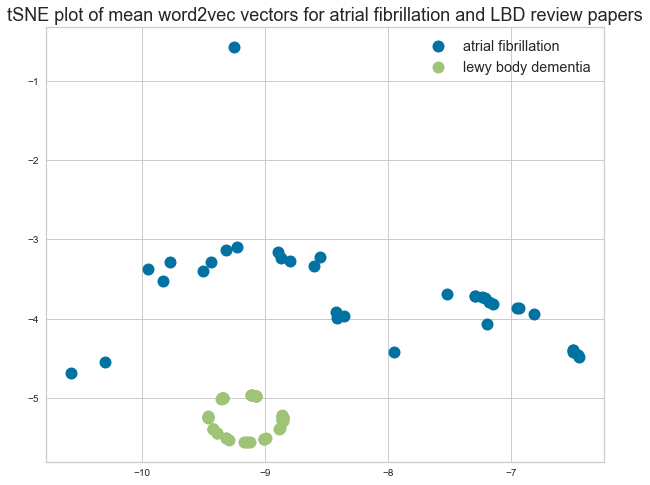

In [183]:
# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

disease_dict = {'af':'atrial fibrillation', 'lbd':'lewy body dementia'}

for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=disease_dict[name])
ax.legend()
plt.title("tSNE plot of mean word2vec vectors for atrial fibrillation and LBD review papers", )

fig = plt.gcf()
fig.savefig('figures/af_lbd_tsne3.png')

plt.show()

## Clustering algorithms

We'll try using different clustering algorithms, to see if any of them can even separate atrial fibrillation and Lewy body dementia papers.

We'll try K-means, agglomerative clustering, and also DB scan to see if they work.

In [48]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer

In [571]:
est = KMeans(n_clusters=3)

In [572]:
urgh = test_df[['x', 'y']]

In [573]:
est.fit(urgh)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [574]:
est.cluster_centers_

array([[403.55145264,  31.2777462 ],
       [-23.44174771,  75.69896594],
       [-18.18564761, -62.093116  ]])

In [575]:
est.labels_

array([1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 2,
       2, 0], dtype=int32)

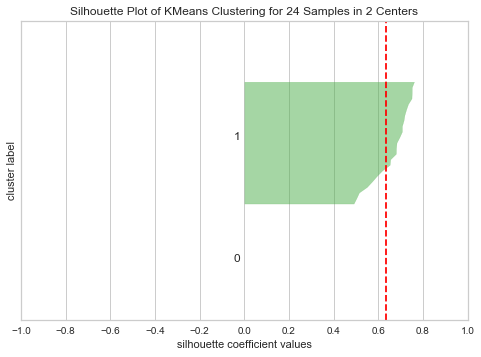

In [576]:
# Instantiate the clustering model and visualizer
visualizer = SilhouetteVisualizer(KMeans(n_clusters=2))
visualizer.fit(urgh)
visualizer.poof()

Code to track progress:

In [54]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )